## Latex2Json

In [71]:
import json
from TexSoup import TexSoup as TS

HIERARCHY = ['document', 'section', 'subsection', 'subsubsection', 'paragraph', 'subparagraph']
LEAF_NODES = ['itemize', 'table' , 'enumerate']
MAX_TEXT_LENGTH = 15

def tex_soup_to_json(tex_content):
    doc_index = 0
    content_count = len(tex_content.contents)
    
    for i in range(content_count):
        if not isinstance(tex_content.contents[i], str) and tex_content.contents[i].name == 'document':
            doc_index = i
            break
 
    document_content = tex_content.contents[doc_index]
    node_id = 0
    node_stack = [{'id': node_id, 'name': 'document', 'level': 0, 'type': 'document', 'children': []}]
    node_id += 1

    for element in document_content:
        if isinstance(element, str):
            # Truncate text to fit within MAX_TEXT_LENGTH
            text_length = len(element)
            truncated_text = element[:min(MAX_TEXT_LENGTH, text_length)]
            
            # Create a new node with the text as a hierarchy element
            text_node = {
                'id': node_id,
                'name': truncated_text,
                'type': 'text',
                'level': node_stack[-1]['level'] + 1,
                'children': []
            }
            node_stack[-1]['children'].append(text_node)
            node_id += 1

        elif element.name in HIERARCHY:
            element_depth = HIERARCHY.index(element.name)

            while element_depth <= HIERARCHY.index(node_stack[-1]['type']) and len(node_stack) > 1:
                node_stack.pop()

            if element_depth - 1 == HIERARCHY.index(node_stack[-1]['type']):
                new_node = {
                    'id': node_id,
                    'name': element.contents[0] if element.contents else '',
                    'type': element.name,
                    'children': [],
                    'level': node_stack[-1]['level'] + 1
                }
                node_stack[-1]['children'].append(new_node)
                node_stack.append(new_node)
                node_id += 1
            elif len(node_stack) > 1:
                raise Exception("Document is not structured with proper hierarchy")
        
        elif element.name in LEAF_NODES:

            children = []
            if element.name == 'enumerate' or element.name == 'itemize':
                # edit the count of the children and their level
                for item in element.contents:
                    text_node = {
                        'id': node_id,
                        'name': item.contents[0] ,
                        'type': 'text',
                        'level': node_stack[-1]['level'] + 2, ##
                        'children': []
                                }
                    children.append(text_node)                    
                    node_id+=1##                    
                    


            leaf_node = {
                'id': node_id,
                'name': element.name,
                'level': node_stack[-1]['level'] + 1,
                'type': element.name,
                'children': children
            }
        
        
            node_stack[-1]['children'].append(leaf_node)
            node_id += 1

    return node_stack[0]

def tex_file_to_json(file_path):
    # Read the .tex file content
    with open(file_path) as file:
        tex_data = file.read()
    
    # Parse the TeX content to JSON structure
    tex_soup = TS(tex_data)
    json_data = tex_soup_to_json(tex_soup)
    
    # Save the JSON output to a file with the same name as the input but with .json extension
    json_file_path = file_path.rsplit('.', 1)[0] + '.json'
    with open(json_file_path, 'w') as json_file:
        json.dump(json_data, json_file, indent=4)
    
    print(f"JSON output saved to {json_file_path}")

# Example usage
# tex_file_to_json('example.tex')


In [72]:
tex_file_to_json("/home/azureuser/cloudfiles/code/Users/omar.bayoumi/structure-testing/test.md")

JSON output saved to /home/azureuser/cloudfiles/code/Users/omar.bayoumi/structure-testing/test.json


## Standardize headings

In [7]:
import re
from difflib import SequenceMatcher
import copy
import json


import json

def load_and_validate_json(file_path):
    """
    Load a JSON file and validate that it contains the expected structure
    with a 'children' field at the root level.

    Parameters:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The loaded JSON data.

    Raises:
        ValueError: If the JSON does not have the expected structure.
    """
    # Load JSON file
    with open(file_path, 'r') as f:
        json_data = json.load(f)
        print(f"JSON file '{file_path}' loaded successfully")

    # Validate JSON structure
    if not isinstance(json_data, dict):
        raise ValueError(f"The JSON file '{file_path}' must be a dictionary at the root level.")
    
    if 'children' not in json_data:
        raise ValueError(f"The JSON file '{file_path}' must contain a 'children' field at the root level.")
    
    return json_data

# Example usage:
# gt_json = load_and_validate_json('ground_truth.json')
# pred_json = load_and_validate_json('prediction.json')




def normalize_text(text):
    """Normalize text for comparison by removing special characters and standardizing spacing."""
    # Convert to lowercase
    text = text.lower()
    # Replace special characters with spaces
    text = re.sub(r'[.,(){}[\]\'\"#]', ' ', text)
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    # Strip leading/trailing whitespace
    return text.strip()

def calculate_similarity(text1, text2):
    """Calculate similarity ratio between two texts after normalization."""
    norm_text1 = normalize_text(text1)
    norm_text2 = normalize_text(text2)
    return SequenceMatcher(None, norm_text1, norm_text2).ratio()

def find_matching_headings(pred_json, gt_json, similarity_threshold=0.75):
    """Find matching headings between predicted and ground truth JSONs."""
    HEADING_TYPES = ['document', 'section', 'subsection', 'subsubsection', 'paragraph', 'subparagraph']
    matches = []
    changes = []
    
    def collect_headings(node, headings):
        if isinstance(node, dict) and node.get('type') in HEADING_TYPES:
            headings.append(node)
        if isinstance(node, dict) and 'children' in node:
            for child in node['children']:
                collect_headings(child, headings)
    
    pred_headings = []
    gt_headings = []
    collect_headings(pred_json, pred_headings)
    collect_headings(gt_json, gt_headings)
    
    # Find matches without type constraint
    for pred_heading in pred_headings:
        best_match = None
        best_similarity = similarity_threshold
        
        for gt_heading in gt_headings:
            similarity = calculate_similarity(pred_heading['name'], gt_heading['name'])
            if similarity > best_similarity:
                best_similarity = similarity
                best_match = gt_heading
        
        if best_match:
            matches.append((pred_heading, best_match))
            if pred_heading['name'] != best_match['name']:
                changes.append({
                    'original': pred_heading['name'],
                    'replaced_with': best_match['name'],
                    'similarity': best_similarity,
                    'original_type': pred_heading['type'],
                    'matched_type': best_match['type']
                })
    
    return matches, changes

def update_json_headings(json_data, matches):
    """Update the predicted JSON with matching heading names from ground truth."""
    updated_json = copy.deepcopy(json_data)
    
    def update_node(node):
        for match_pred, match_gt in matches:
            if isinstance(node, dict) and node.get('id') == match_pred['id']:
                node['name'] = match_gt['name']
        
        if isinstance(node, dict) and 'children' in node:
            for child in node['children']:
                update_node(child)
    
    update_node(updated_json)
    return updated_json

def normalize_headings(pred_json, gt_json):
    """Main function to normalize headings in predicted JSON based on ground truth."""
    matches, changes = find_matching_headings(pred_json, gt_json)
    updated_json = update_json_headings(pred_json, matches)
    
    return updated_json, changes

In [9]:
gt_file = 'gt_json.json'
pred_file = 'pred_json.json'

gt_json = load_and_validate_json(gt_file)
pred_json = load_and_validate_json(pred_file)


# Assuming pred_json and gt_json are your input JSONs
updated_json, changes = normalize_headings(pred_json, gt_json)

# Save the updated JSON to a new file
updated_json_file = 'updated_pred_json.json'
with open(updated_json_file, 'w') as f:
    json.dump(updated_json, f, indent=4)
    print(f"Updated JSON saved to '{updated_json_file}'")   



# Print report of changes
print("Heading Normalization Report:")
print("-" * 50)
for change in changes:
    print(f"Original: {change['original']} ({change['original_type']})")
    print(f"Replaced with: {change['replaced_with']} ({change['matched_type']})")
    print(f"Similarity score: {change['similarity']:.2f}")
    print("-" * 50)

JSON file 'gt_json.json' loaded successfully
JSON file 'pred_json.json' loaded successfully
Updated JSON saved to 'updated_pred_json.json'
Heading Normalization Report:
--------------------------------------------------
Original: item1-Business (section)
Replaced with: item1 - Business (section)
Similarity score: 0.93
--------------------------------------------------
Original: Business visions (a) (subsection)
Replaced with: Business vision (subsection)
Similarity score: 0.91
--------------------------------------------------
Original:  - Strategy (subsubsection)
Replaced with: Strategy (subsection)
Similarity score: 0.89
--------------------------------------------------
Original:  - item 2 (a)- Risk (section)
Replaced with: item2 - Risk (section)
Similarity score: 0.83
--------------------------------------------------


## Text Block Extractor

In [89]:
def extract_text(data, current_heading=None, result=None):
    if result is None:
        result = []
        
    # Check if the current node has children and iterate through them
    if "children" in data:
        for child in data["children"]:
            # If the child is a heading (section, subsection, subsubsection, or paragraph)
            if child["type"] in ["document" ,"section", "subsection", "subsubsection", "paragraph" , "subparagraph", "itemize", "enumerate"]:
                # Update the current heading name
                new_heading = child["name"]
                extract_text(child, new_heading, result)
                
            # If the child is of type "text," concatenate it to the current heading's text
            elif child["type"] == "text" and current_heading is not None:
                # Check if there's an existing entry for the current heading in the result
                existing_entry = next((item for item in result if current_heading in item), None)
                if existing_entry:
                    existing_entry[current_heading] += child["name"]
                else:
                    result.append({current_heading: child["name"]})
                    
            # Recursively process the remaining children
            else:
                extract_text(child, current_heading, result)
    
    return result



In [90]:

test = load_and_validate_json('test.json')
# Get the list of dictionaries with headings and concatenated text
output = extract_text(test)
print(output)


JSON file 'test.json' loaded successfully
[{'Price Range of Our Common Stock and Preferred Stock': '\nOur common sto'}, {'Dividends': '\nWe have not de'}, {'Shareholder Information': '\nOur shareholde'}, {'Overview': '\nThe following '}, {'Financial Highlights': '\n2019 saw an in\\%...\n\nOur profit'}, {'Executive Officers': '\nThe company’s '}, {'Governance Practices': '\nOur governance'}, {'itemize': ' Ensure compliance with all relevant regulations.\n     Monitor industry trends for emerging risks.\n     Engage with stakeholders to gather insights on potential threats.\n'}, {'Governance ': '\nwe do imp thin'}]


## DAR 

In [29]:
import json
from typing import Dict, List, Set, Tuple
from collections import defaultdict

class RelationType:
    PARENT_CHILD = "parent_child"
    SIBLING = "sibling"
    COMBINED = "combined"

class NodeInfo:
    def __init__(self, name: str, type: str):
        self.name = name
        self.type = type
    
    def __str__(self):
        return f"{self.name} (Type: {self.type})"

def validate_node(node: Dict) -> bool:
    """Validate that a node has all required fields and correct types"""
    required_fields = {'name': str, 'type': str}
    
    for field, expected_type in required_fields.items():
        if field not in node:
            raise ValueError(f"Missing required field '{field}' in node: {node}")
        if not isinstance(node[field], expected_type):
            raise ValueError(f"Field '{field}' in node has wrong type. Expected {expected_type}, got {type(node[field])}. Node: {node}")
    
    if 'children' in node and not isinstance(node['children'], list):
        raise ValueError(f"Field 'children' must be a list. Node: {node}")
    
    return True

def extract_relations(hierarchy: Dict) -> Dict[str, Set[Tuple[str, str]]]:
    """
    Extract parent-child and unidirectional sibling relations from a heading hierarchy.
    Relations are stored using node names. Includes relations from the root document node.
    """
    parent_child_relations = set()
    sibling_relations = set()
    
    def process_siblings(siblings: List[Dict]):
        """Process sibling relationships among a list of nodes"""
        if not siblings:
            return
            
        try:
            for node in siblings:
                validate_node(node)
            
            sibling_names = [node['name'] for node in siblings]
            for i in range(len(sibling_names)):
                for j in range(i + 1, len(sibling_names)):
                    sibling_relations.add((sibling_names[i], sibling_names[j]))
        except Exception as e:
            print(f"Error processing siblings: {siblings}")
            raise
    
    def process_node(node: Dict):
        """Process a single node and its children"""
        try:
            validate_node(node)
            current_name = node['name']
            
            if 'children' in node and node['children']:
                children = node['children']
                # Process parent-child relations
                for child in children:
                    validate_node(child)
                    parent_child_relations.add((current_name, child['name']))
                    process_node(child)
                # Process sibling relations among children
                process_siblings(children)
        except Exception as e:
            print(f"Error processing node: {node}")
            raise
    
    # Start processing from root
    if not isinstance(hierarchy, dict):
        raise ValueError(f"Hierarchy must be a dictionary, got {type(hierarchy)}")
    
    # Validate root node
    if 'name' not in hierarchy or 'type' not in hierarchy:
        # If root doesn't have name/type, assume it's a document root
        hierarchy['name'] = 'document'
        hierarchy['type'] = 'root'
    
    validate_node(hierarchy)
    
    if 'children' not in hierarchy:
        raise ValueError("Root node must have 'children' field")
        
    if not isinstance(hierarchy['children'], list):
        raise ValueError("Root 'children' must be a list")
    
    root_children = hierarchy['children']
    
    # Process root's relations with its immediate children
    for child in root_children:
        validate_node(child)
        parent_child_relations.add((hierarchy['name'], child['name']))
    
    # Process siblings at root level
    process_siblings(root_children)
    
    # Process each child node and its descendants
    for node in root_children:
        process_node(node)
    
    return {
        RelationType.PARENT_CHILD: parent_child_relations,
        RelationType.SIBLING: sibling_relations
    }

def build_node_info_map(hierarchy: Dict) -> Dict[str, NodeInfo]:
    """Build a mapping of node names to their information"""
    node_map = {}
    
    # Add root node to the map if it has name and type
    if 'name' in hierarchy and 'type' in hierarchy:
        node_map[hierarchy['name']] = NodeInfo(hierarchy['name'], hierarchy['type'])
    elif 'children' in hierarchy:  # Add default document root if not specified
        node_map['document'] = NodeInfo('document', 'root')
    
    def process_node(node: Dict):
        try:
            validate_node(node)
            node_map[node['name']] = NodeInfo(node['name'], node['type'])
            if 'children' in node and node['children']:
                for child in node['children']:
                    process_node(child)
        except Exception as e:
            print(f"Error processing node in build_node_info_map: {node}")
            raise
    
    if 'children' in hierarchy:
        for node in hierarchy['children']:
            process_node(node)
    
    return node_map

In [30]:


def calculate_metrics_by_type(gt_relations: Set[Tuple[int, int]], 
                            pred_relations: Set[Tuple[int, int]]) -> Dict[str, float]:
    """Calculate metrics for a specific relation type."""
    true_positives = gt_relations.intersection(pred_relations)
    false_positives = pred_relations - gt_relations
    false_negatives = gt_relations - pred_relations
    
    tp_count = len(true_positives)
    fp_count = len(false_positives)
    fn_count = len(false_negatives)
    
    precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
    recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    total_relations = len(gt_relations.union(pred_relations))
    accuracy = tp_count / total_relations if total_relations > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'details': {
            'true_positives': true_positives,
            'false_positives': false_positives,
            'false_negatives': false_negatives
        }
    }

def print_relation(relation: Tuple[int, int], node_map: Dict[int, NodeInfo]):
    """Print a relation with both IDs and names"""
    try:
        source = node_map[relation[0]]
        target = node_map[relation[1]]
        print(f"  {source} → {target}")
    except KeyError as e:
        print(f"Error: Could not find node with ID {e} in node map")

def print_scores(metrics: Dict[str, Dict[str, float]]):
    """Print scores for all relation types."""
    print("\n=== EVALUATION SCORES ===\n")
    
    for relation_type in [RelationType.PARENT_CHILD, RelationType.SIBLING, RelationType.COMBINED]:
        print(f"\n{relation_type.upper()} SCORES:")
        print("-" * (len(relation_type) + 8))
        for metric, value in metrics[relation_type].items():
            if metric != 'details':
                print(f"{metric}: {value:.3f}")

def print_relation_analysis(gt_relations: Dict[str, Set[Tuple[int, int]]], 
                          pred_relations: Dict[str, Set[Tuple[int, int]]], 
                          metrics: Dict[str, Dict[str, float]],
                          gt_node_map: Dict[int, NodeInfo],
                          pred_node_map: Dict[int, NodeInfo]):
    """Print detailed analysis of relations and metrics."""
    print("\n=== DETAILED RELATION ANALYSIS ===\n")
    
    for relation_type in [RelationType.PARENT_CHILD, RelationType.SIBLING, RelationType.COMBINED]:
        print(f"\n{relation_type.upper()} RELATIONS:")
        print("=" * (len(relation_type) + 10))
        
        if relation_type != RelationType.COMBINED:
            print("\nGround Truth Relations:")
            print("-" * 20)
            for relation in sorted(gt_relations[relation_type]):
                print_relation(relation, gt_node_map)
            
            print("\nPredicted Relations:")
            print("-" * 19)
            for relation in sorted(pred_relations[relation_type]):
                print_relation(relation, pred_node_map)
        
        details = metrics[relation_type]['details']
        
        print("\nCorrect Predictions (True Positives):")
        print("-" * 35)
        for relation in sorted(details['true_positives']):
            print_relation(relation, gt_node_map)
        
        print("\nMissed Relations (False Negatives):")
        print("-" * 33)
        for relation in sorted(details['false_negatives']):
            print_relation(relation, gt_node_map)
        
        print("\nIncorrect Predictions (False Positives):")
        print("-" * 37)
        for relation in sorted(details['false_positives']):
            print_relation(relation, pred_node_map)
        
        print("\n" + "="*50)


In [31]:
def evaluate_hierarchy(gt_file: str, pred_file: str, print_details: bool = False) -> Dict[str, Dict[str, float]]:
    """
    Evaluate predicted heading hierarchy against ground truth using different relation types.
    """
    try:
        # Load JSON files
        with open(gt_file, 'r') as f:
            gt_json = json.load(f)
            print("Ground truth JSON loaded successfully")
        
        with open(pred_file, 'r') as f:
            pred_json = json.load(f)
            print("Predicted JSON loaded successfully")
        
        # Validate root structure
        if not isinstance(gt_json, dict) or not isinstance(pred_json, dict):
            raise ValueError("Both ground truth and predicted JSON must be dictionaries")
        
        if 'children' not in gt_json or 'children' not in pred_json:
            raise ValueError("Both JSON structures must have a 'children' field at root level")
        
        # Build node info maps
        gt_node_map = build_node_info_map(gt_json)
        pred_node_map = build_node_info_map(pred_json)
        
        # Extract relations
        gt_relations = extract_relations(gt_json)
        pred_relations = extract_relations(pred_json)
        
        # Calculate metrics for each case
        metrics = {}
        
        # Case 1: Parent-child relations only
        metrics[RelationType.PARENT_CHILD] = calculate_metrics_by_type(
            gt_relations[RelationType.PARENT_CHILD],
            pred_relations[RelationType.PARENT_CHILD]
        )
        
        # Case 2: Sibling relations only
        metrics[RelationType.SIBLING] = calculate_metrics_by_type(
            gt_relations[RelationType.SIBLING],
            pred_relations[RelationType.SIBLING]
        )
        
        # Case 3: Combined relations
        combined_gt = gt_relations[RelationType.PARENT_CHILD].union(gt_relations[RelationType.SIBLING])
        combined_pred = pred_relations[RelationType.PARENT_CHILD].union(pred_relations[RelationType.SIBLING])
        metrics[RelationType.COMBINED] = calculate_metrics_by_type(combined_gt, combined_pred)
        
        # Always print scores
        print_scores(metrics)
        
        # Print detailed analysis if requested
        if print_details:
            print_relation_analysis(gt_relations, pred_relations, metrics, gt_node_map, pred_node_map)
        
        return metrics
    
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        raise
    except json.JSONDecodeError as e:
        print(f"Invalid JSON format: {e}")
        raise
    except ValueError as e:
        print(f"Validation error: {e}")
        raise
    except Exception as e:
        print(f"Unexpected error: {e}")
        raise

## main

In [65]:
try:
    metrics = evaluate_hierarchy('test.json', 'test.json', print_details=True)
except Exception as e:
    print(f"Error during evaluation: {e}")

Ground truth JSON loaded successfully
Predicted JSON loaded successfully

=== EVALUATION SCORES ===


PARENT_CHILD SCORES:
--------------------
precision: 1.000
recall: 1.000
f1: 1.000
accuracy: 1.000

SIBLING SCORES:
---------------
precision: 1.000
recall: 1.000
f1: 1.000
accuracy: 1.000

COMBINED SCORES:
----------------
precision: 1.000
recall: 1.000
f1: 1.000
accuracy: 1.000

=== DETAILED RELATION ANALYSIS ===


PARENT_CHILD RELATIONS:

Ground Truth Relations:
--------------------
  Compliance and Risk Monitoring (Type: paragraph) → itemize (Type: itemize)
  Dividends (Type: subsubsection) → 
We have not de (Type: text)
  Dividends (Type: subsubsection) → Shareholder Information (Type: paragraph)
  Executive Officers (Type: subsection) → 
The company’s  (Type: text)
  Executive Officers (Type: subsection) → Governance Practices (Type: subsubsection)
  Financial Highlights (Type: subsubsection) → 
2019 saw an in (Type: text)
  Financial Highlights (Type: subsubsection) → ...

Our p

- Standardize parent nodes [done]
- Wrap text as node with no children (not floating text) [done]
- apply on real text from SEC and iterate with json2latex 
    - doc to children types [done] 
    - nodes -> text [done]
    - itemize -> text [done]

### graph plotter

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
 
def add_edges(graph, node, parent=None):
    """Recursively add directed edges to the graph based on TreeOfContents structure."""
    # Set the node name based on whether the node is a string or dictionary
 
    smol = {'document' : 'doc', 'section':'sec', 'subsection':'ssec', 'subsubsection':'sssec', 'paragraph' : 'pg', 'subparagraph':'spg'}
    
 
    node_name = ('Text:\n\n' + node[0:min(10, len(node))] )if isinstance(node, str) else ( smol[node['type']] if node['type']  in smol else  node['type']) + ':\n\n' + node['name'] + str (node['id'])
    
    if parent:
        parent_name = parent
        graph.add_edge(parent_name, node_name)
 
    if isinstance(node, str):
        return
 
    for child in node['children']:
        add_edges(graph, child, node_name)
 
 
def draw_dict(dictt):
    """Draw the TreeOfContents as a directed graph with improved layout and readability."""
    # Create a directed graph
    graph = nx.DiGraph()
    
    # Recursively add nodes and edges
    add_edges(graph, dictt)
 
    # Use a hierarchical layout for a clearer structure
    pos = graphviz_layout(graph, prog="dot")  
    
    plt.figure(figsize=(15, 10))  # Larger figure size for readability
    nx.draw(
        graph, pos, with_labels=True, node_size=200, node_color="skyblue",
        font_size=10, font_weight="bold", font_color="black", arrows=True, arrowstyle='->', arrowsize=15
    )
    plt.title("LaTeX Document Structure Tree (Directed)")
    plt.show()

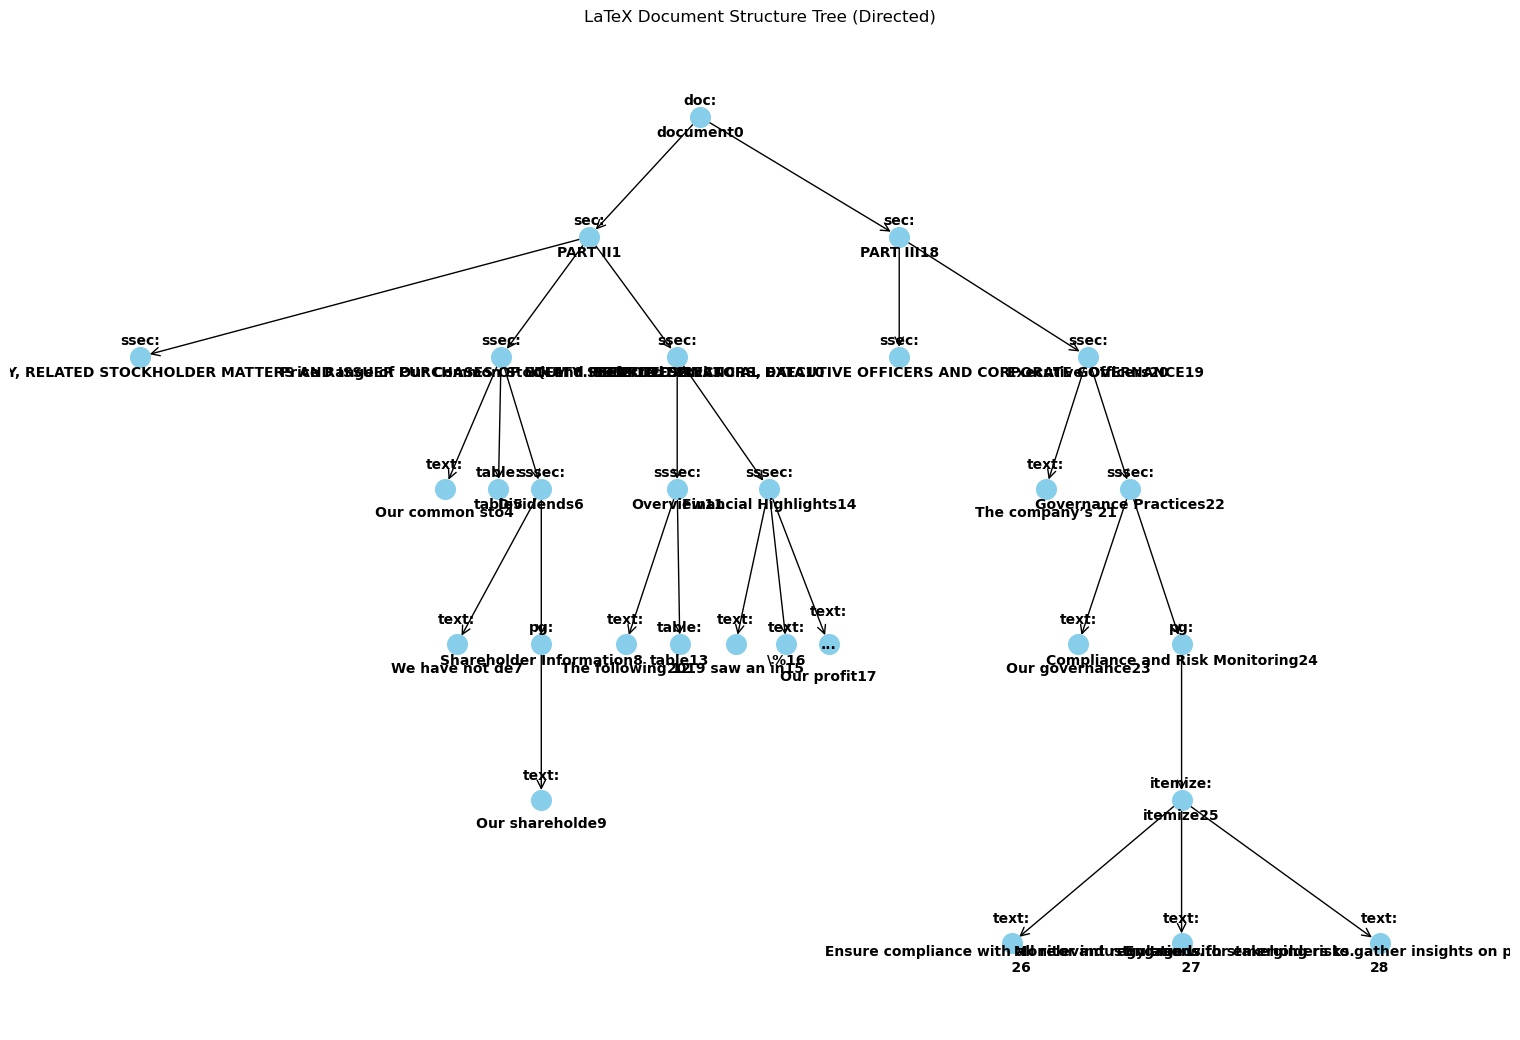

In [66]:
import json

def read_json_file_as_dict(file_path):
    with open(file_path, 'r') as file:
        data_dict = json.load(file)
    return data_dict

# Example usage
file_path = 'test.json'
data_dict = read_json_file_as_dict(file_path)


draw_dict(data_dict)
